In [2]:
# Importing necessary modules
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import NearMiss


In [3]:
# Load dataset
df = pd.read_csv('rawdata/combined_iot_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")
print(f"\nDevice: {df['device'].unique()}")


Dataset shape: (701648, 117)

Class distribution:
label
Mirai     652100
Benign     49548
Name: count, dtype: int64

Device: ['DanminiDoorbell']


In [4]:
def knn_classifier(data, device_name, scaling=True, balancing=True, n_neighbors=3):
    """
    KNN Classifier 

    """
    # Prepare data
    X = data.drop(['label', 'device'], axis=1).values
    y = data['label'].values
    feature_names = list(data.drop(['label', 'device'], axis=1).columns)
    
    print(f"\n{'='*70}")
    print(f"KNN CLASSIFIER - {device_name}")
    print(f"Scaling: {scaling} | Balancing: {balancing} | K={n_neighbors}")
    print(f"{'='*70}")
    print(f"Original Shape: {X.shape}, {y.shape}")
    
    # Balancing with NearMiss
    if balancing:
        nm = NearMiss()
        X, y = nm.fit_resample(X, y)
        print(f"Balanced Shape: {X.shape}, {y.shape}")
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=47
    )
    
    # Scaling with StandardScaler
    scaler = None
    if scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Training KNN
    print("\nTraining KNN model...")
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    # Predict
    y_pred = knn.predict(X_test)
    
    # Calculate metrics
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    # Show results
    print(f"\n{'='*70}")
    print("RESULTS")
    print(f"{'='*70}")
    print(f"Train Accuracy: {train_acc:.6f}")
    print(f"Test Accuracy:  {test_acc:.6f}")
    print(f"F1-Score:       {f1:.6f}")
    print(f"\nConfusion Matrix:\n{cm}")
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")
    
    # Save model
    model_path = 'models'
    os.makedirs(model_path, exist_ok=True)
    
    scaling_str = "scaled" if scaling else "unscaled"
    balancing_str = "balanced" if balancing else "unbalanced"
    model_name = f"{device_name}_KNN_{balancing_str}_{scaling_str}_k{n_neighbors}.pkl"
    model_full_path = os.path.join(model_path, model_name)
    
    model_data = {
        'model': knn,
        'scaler': scaler,
        'feature_names': feature_names,
        'classes': list(np.unique(y)),
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'f1_score': f1,
        'n_neighbors': n_neighbors,
        'device_name': device_name
    }
    
    with open(model_full_path, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"\n✓ Model saved: {model_full_path}")
    print("="*70)
    
    return model_data


In [5]:
# Train KNN with the best configuration (balanced + scaled)
results = knn_classifier(
    data=df,
    device_name='DanminiDoorbell',
    scaling=True,
    balancing=False,
    n_neighbors=3
)



KNN CLASSIFIER - DanminiDoorbell
Scaling: True | Balancing: False | K=3
Original Shape: (701648, 115), (701648,)

Training KNN model...

RESULTS
Train Accuracy: 0.999980
Test Accuracy:  0.999981
F1-Score:       0.999981

Confusion Matrix:
[[ 14866      1]
 [     3 195625]]

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     14867
       Mirai       1.00      1.00      1.00    195628

    accuracy                           1.00    210495
   macro avg       1.00      1.00      1.00    210495
weighted avg       1.00      1.00      1.00    210495


✓ Model saved: models\DanminiDoorbell_KNN_unbalanced_scaled_k3.pkl


In [6]:
# Try different k values
k_values = [3, 5, 7, 9]
comparison_results = []

for k in k_values:
    print(f"\n{'#'*70}")
    print(f"Testing K={k}")
    print(f"{'#'*70}")
    
    result = knn_classifier(
        data=df,
        device_name='DanminiDoorbell',
        scaling=True,
        balancing=True,
        n_neighbors=k
    )
    
    comparison_results.append({
        'K': k,
        'Train Accuracy': result['train_accuracy'],
        'Test Accuracy': result['test_accuracy'],
        'F1-Score': result['f1_score']
    })

# Show comparison
comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*70)
print("K-VALUE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))



######################################################################
Testing K=3
######################################################################

KNN CLASSIFIER - DanminiDoorbell
Scaling: True | Balancing: True | K=3
Original Shape: (701648, 115), (701648,)
Balanced Shape: (99096, 115), (99096,)

Training KNN model...

RESULTS
Train Accuracy: 0.999986
Test Accuracy:  1.000000
F1-Score:       1.000000

Confusion Matrix:
[[14843     0]
 [    0 14886]]

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     14843
       Mirai       1.00      1.00      1.00     14886

    accuracy                           1.00     29729
   macro avg       1.00      1.00      1.00     29729
weighted avg       1.00      1.00      1.00     29729


✓ Model saved: models\DanminiDoorbell_KNN_balanced_scaled_k3.pkl

######################################################################
Testing K=5
###################################

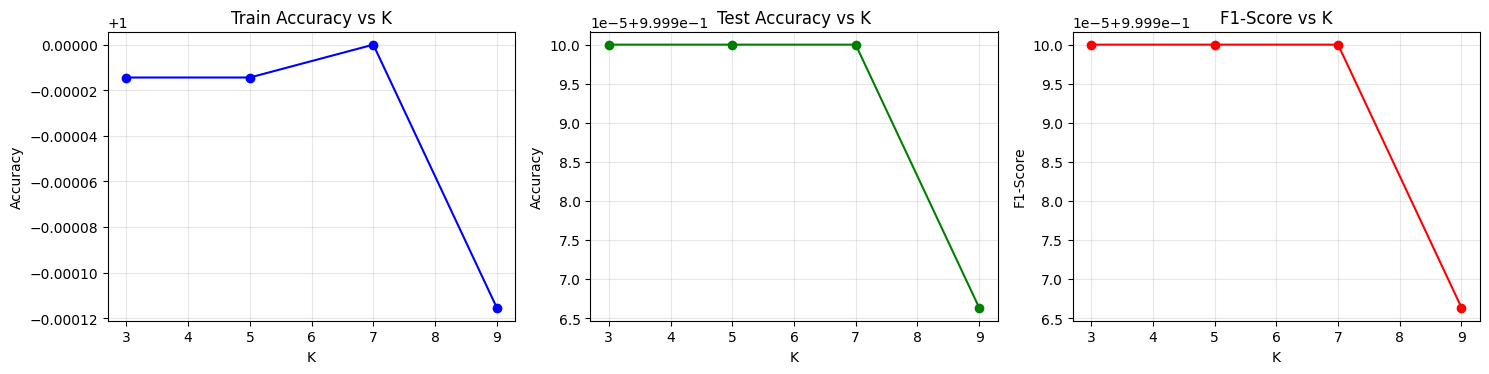


✓ Best K value: 3


In [7]:
# Visualize performance vs K
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

comparison_df.plot(x='K', y='Train Accuracy', kind='line', marker='o', ax=axes[0], color='blue', legend=False)
axes[0].set_title('Train Accuracy vs K')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True, alpha=0.3)

comparison_df.plot(x='K', y='Test Accuracy', kind='line', marker='o', ax=axes[1], color='green', legend=False)
axes[1].set_title('Test Accuracy vs K')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True, alpha=0.3)

comparison_df.plot(x='K', y='F1-Score', kind='line', marker='o', ax=axes[2], color='red', legend=False)
axes[2].set_title('F1-Score vs K')
axes[2].set_ylabel('F1-Score')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best K
best_k = comparison_df.loc[comparison_df['Test Accuracy'].idxmax(), 'K']
print(f"\n✓ Best K value: {int(best_k)}")


In [8]:
# Load the best model (K=3, balanced, scaled)
model_path = 'models/DanminiDoorbell_KNN_balanced_scaled_k3.pkl'

with open(model_path, 'rb') as f:
    model_data = pickle.load(f)

loaded_knn = model_data['model']
loaded_scaler = model_data['scaler']
feature_names = model_data['feature_names']
classes = model_data['classes']

print(f"✓ Model loaded: {model_path}")
print(f"\nModel Information:")
print(f"  - Device: {model_data['device_name']}")
print(f"  - K neighbors: {model_data['n_neighbors']}")
print(f"  - Classes: {classes}")
print(f"  - Features: {len(feature_names)}")
print(f"  - Test Accuracy: {model_data['test_accuracy']:.6f}")
print(f"  - F1-Score: {model_data['f1_score']:.6f}")


✓ Model loaded: models/DanminiDoorbell_KNN_balanced_scaled_k3.pkl

Model Information:
  - Device: DanminiDoorbell
  - K neighbors: 3
  - Classes: ['Benign', 'Mirai']
  - Features: 115
  - Test Accuracy: 1.000000
  - F1-Score: 1.000000
